In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import os, sys, glob

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
import cellshapy

In [ ]:
data_folder = '/Users/wdeback/Work/celldynamics/data_simulated/ellipses/'
#data_folder = '/Users/wdeback/Work/celldynamics/data_simulated/SweepNPF_46/**'
#data_folder = '/Users/wdeback/Simulation/Example-Protrusion_sweep_97/**' # jakub-like synthetic data
data_folder = '/Users/wdeback/Simulation/Example-Protrusion_sweep_90/**'

#data_folder = '../data/DEV_CELL_PAPER/**'
tifstack_fn = '*.tif' 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import os, sys, glob
from IPython.display import HTML
%load_ext autoreload
%autoreload 2
import cellshapy

In [ ]:
paths = glob.glob(os.path.join(data_folder, tifstack_fn))

In [ ]:
annotations = []
for i in range(len(paths)):
    annotation = dict()
    annotation['label'] = int(i//10)
    annotations.append(annotation)
annotations

In [ ]:
videos = cellshapy.VideoCollection.from_filenames(paths, 
                                                  annotations=annotations, 
                                                  composite=True)


In [ ]:
_ = videos.align_contours()

In [2]:
def import_tissue():
    data_folder = '/Users/wdeback/Simulation/Simulation_9848'
    
    import pandas as pd
    df = pd.read_csv(os.path.join(data_folder, 'logger.csv'), sep='\t')

    annotations = [{'label': row['shrinking']} for i, row in df.iterrows()]
    path_glob = os.path.join(data_folder, 'image_*.tif')
    videos = cellshapy.VideoCollection.from_glob(path_glob, 
                                                 annotations=annotations,
                                                 composite=True, 
                                                 min_size=0, 
                                                 n_jobs=-1)
    videos.align_contours()
    return videos

In [3]:
videos = import_tissue()

Creating VideoCollection from glob expression /Users/wdeback/Simulation/Simulation_9848/image_*.tif: 196 video files or directories
Creating VideoCollection from list of paths. 196 video files or directories



Iteration 2, error: 0.000052, time: 32.87 sec
8036 contours aligned in 48.45 sec


# Frames

`pca` embedding for `features` done (0.16 s).
`pca` embedding for `contours` done (0.06 s).


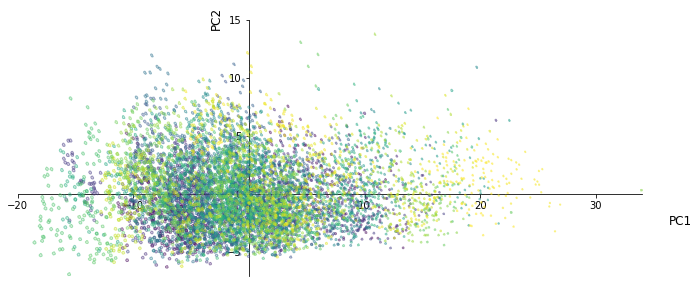

In [30]:
videos.embed_frames('all','pca', n_components=2)
_ = videos.shape_space('features','pca', shape_size=5.0)
_ = videos.shape_space('contours','pca', shape_size=5.0)


In [ ]:
_, recon_contours, recon_positions = videos.shape_space_reconstruction('contours','pca', 
                                                                       shape_size=50.0, 
                                                                       num_points=8, 
                                                                       num_dimensions=2, 
                                                                       alpha_face=0.8,
                                                                       alpha_edge=1.0,
                                                                       return_contours=True)


In [ ]:
#videos.polar_shape_space('contours','pca', shape_size=5.0, label_threshold=0.0)

In [ ]:
df_frames = videos.shape_space_correlate_with_features('contours','pca', num_points=5, num_dimensions=2, correlation_method='pearson')
df_frames

- Top 5 

In [ ]:
df_frames['PC1'].sort_values(ascending=False).map('{:.3f}'.format).head(n=5)


In [ ]:
df_frames['PC2'].sort_values(ascending=False).map('{:.3f}'.format).head(n=5)


# Video

- embed videos as usual

`parafac` embedding for `stxy`

Using numpy backend.


 done (1.13 s).


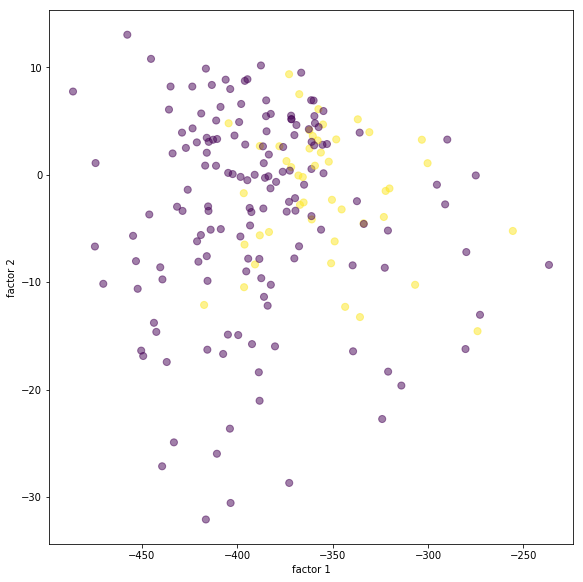

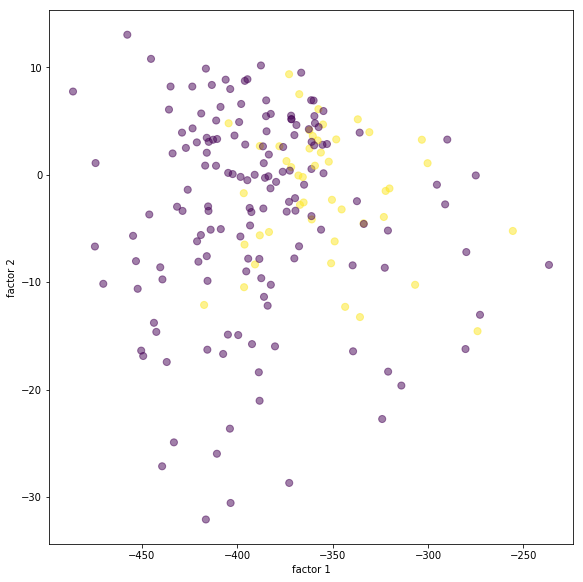

In [4]:
videos.embed_videos('stxy', 'parafac', n_components=2)
videos.morph_space('stxy', 'parafac', shape_size=50, duration=5.0, colorcode='label', 
                  show_shapes=False)

#anim = videos.morph_space('stxy', 'parafac', shape_size=0.05, duration=5.0, colorcode='label')
#anim

- choose a reasonble n_components to separate labels

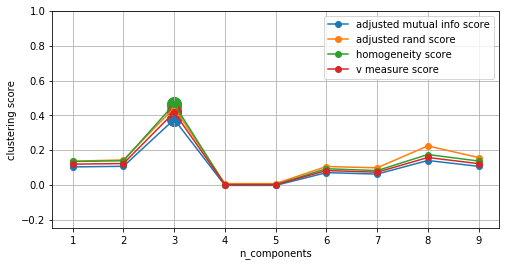

In [5]:
from cellshapy.analysis.embedding import embedding_clustering_scores
labels = [v.annotations['label'] for v in videos]
culster_scores = embedding_clustering_scores(videos, 'stxy', 'parafac', ground_truth=labels, 
                            cluster_method='kmeans',
                            max_components=10, plot=True)


- perform reconstruction

In [ ]:
anim, recon_contours, recon_positions, num_points = \
                        videos.morph_space_reconstruction('stxy', 'parafac', 
                                  num_points=50, num_dimensions=2, sigma=[10,2],
                                  shape_size=0.1, duration=5.0,
                                  return_contours=True)
anim

- correlate video features with parafac factors

In [ ]:
df_morph = videos.morph_space_correlate_with_features('stxy', 'parafac', 
                                                      num_points=5, num_dimensions=2)

In [ ]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
df_morph.sort_values(by='Factor 1').head(10)

- Top 10 Factor 1

In [ ]:
df_morph['Factor 1'].sort_values(ascending=False).map('{:.3f}'.format).head(n=10)


In [ ]:
df_morph['Factor 1'].sort_values(ascending=True).map('{:.3f}'.format).head(n=10)

- Top 10 Factor 2

In [ ]:
df_morph['Factor 2'].sort_values(ascending=False).map('{:.3f}'.format).head(n=10)


In [ ]:
df_morph['Factor 2'].sort_values(ascending=True).map('{:.3f}'.format).head(n=10)

## Sample from convex hulls 

### Choose a good n_components

In [6]:
from cellshapy.analysis.embedding import tensor_reconstruction_errors, choose_elbow
recon_errors = tensor_reconstruction_errors(videos, 'stxy', 'parafac', max_components=10)
choose_elbow(recon_errors, plot=True)

4

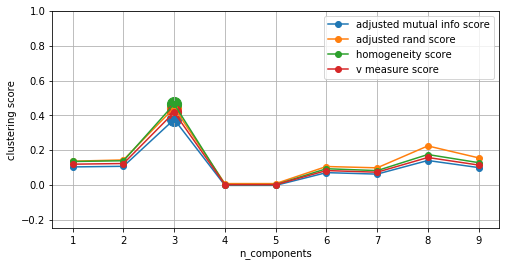

In [7]:
from cellshapy.analysis.embedding import embedding_clustering_scores
labels = [v.annotations['label'] for v in videos]
culster_scores = embedding_clustering_scores(videos, 'stxy', 'parafac', ground_truth=labels, 
                            cluster_method='kmeans',
                            max_components=10, plot=True)


- embed videos in high dimensional space (n_components>2)

In [8]:
videos.embed_videos('stxy', 'parafac', n_components=3)

`parafac` embedding for `stxy` done (1.94 s).


- get position of each video in this space
- separate them according to their `label`

In [9]:
embedding = videos.embedding[('stxy', 'parafac')]
positions = embedding[0]

import numpy as np
positions_0 = np.array([positions[i] for i, v in enumerate(videos) if v.annotations['label'] == 0])
positions_1 = np.array([positions[i] for i, v in enumerate(videos) if v.annotations['label'] == 1])
#positions_2 = [positions[i] for i, v in enumerate(videos) if v.annotations['label'] == 2]

In [10]:
def in_hull(p, hull):
    """
    https://stackoverflow.com/a/16898636
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

def sample_point_in_hull(hull, n=50, max_iter=1e6):
    
    import numpy as np
    samples = np.empty((0, hull.ndim))
    
    c = 0
    while samples.shape[0] < n:
        c += 1
        batch = np.random.random((n*10, hull.ndim)) * (hull.max_bound - hull.min_bound) + hull.min_bound
        batch = batch[in_hull(batch, hull)]
        samples = np.append(samples, batch, axis=0)
        if c > max_iter:
            raise ValueError('Number of iteration ({}) > max_iter ({})'.format(c, max_iter))
        
    return np.array(samples)[:n]

def sample_in_convex_hull(points, n_samples):
    
    from scipy.spatial import Delaunay    
    
    # we cannot build a Delaunay triangulation 
    # if the number of points is small than number of dimensions
    # in this case, we draw additional points from a multivariate Gaussian distribution
    num_points = points.shape[0]
    num_dims   = points.shape[1]
    if num_points > num_dims+2:
        import numpy as np
        print('building convex hull...', end='')
        hull = Delaunay(points)
        print('done')
        print('Sampling from convex hull', end='')
        samples = sample_point_in_hull(hull, n=n_samples)
        print('done')
    else:
        import warnings
        warnings.warn(f"Too few points to construct convex hull ({num_points} < {num_dims+2}). "
                      f"Therefore, we sample from a multivariate Gaussian distribution.")
        import numpy as np
        mean = np.mean(points, axis=0)
        cov = np.cov(points, rowvar=0)
        samples = np.random.multivariate_normal(mean, cov, n_samples)
        #samples = np.vstack([points, new_points])

    return samples

def reconstruct_contours(samples, embedding, format='stxy'):
    import tensorly as tl
    from cellshapy.analysis.embedding import tensor_to_contours

    # reconstruct tensors from these samples and embedding
    tensor = tl.kruskal_to_tensor([samples, *embedding[1:]])
    # reconstruct contours from tensor
    return tensor_to_contours(tensor, format=format)



- get random samples from the convex hulls
- combine them in 1 array

In [12]:
n_samples = 100
positions_0_samples = sample_in_convex_hull(positions_0, n_samples=n_samples)
positions_1_samples = sample_in_convex_hull(positions_1, n_samples=n_samples)
#positions_2_samples = sample_in_convex_hull(positions_2, n_samples=n_samples)

positions_samples = np.vstack([positions_0_samples, positions_1_samples])#, positions_2_samples])

building convex hull...done
Sampling from convex hulldone
building convex hull...done
Sampling from convex hulldone


- reconstruct tensors and contours from these samples

In [13]:
recon_contours = reconstruct_contours(positions_samples, embedding)

format =  stxy


- create new video collection with sampled contours

In [14]:
annotations2 = [{'label' : int(i//n_samples)} for i in range(len(recon_contours))]
vc_samples = cellshapy.VideoCollection.from_contours(recon_contours, annotations=annotations2)
_ = vc_samples.align_contours()


Iteration 1, error: 0.000000, time: 13.19 sec
8200 contours aligned in 26.25 sec


- check a reasonable n_components

In [15]:
from cellshapy.analysis.embedding import tensor_reconstruction_errors, choose_elbow
recon_errors = tensor_reconstruction_errors(vc_samples, 'stxy', 'parafac', max_components=10)
choose_elbow(recon_errors, plot=True)

`parafac` embedding for `stxy` done (0.11 s).


/Users/wdeback/anaconda/envs/cellshapy/lib/python3.6/site-packages/tensorly-0.4.2-py3.6.egg/tensorly/backend/numpy_backend.py:221: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(S)


3

In [16]:
from cellshapy.analysis.embedding import embedding_clustering_scores
labels = [v.annotations['label'] for v in vc_samples]
culster_scores = embedding_clustering_scores(vc_samples, 'stxy', 'parafac', ground_truth=labels, 
                            cluster_method='kmeans',
                            max_components=10, plot=True)


/Users/wdeback/anaconda/envs/cellshapy/lib/python3.6/site-packages/tensorly-0.4.2-py3.6.egg/tensorly/backend/numpy_backend.py:221: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(S)


In [17]:
vc_samples.embed_videos('stxy', 'parafac', n_components=2)

`parafac` embedding for `stxy` done (1.61 s).


num_videos =  200
num_frames =  41
factors.shape =  2


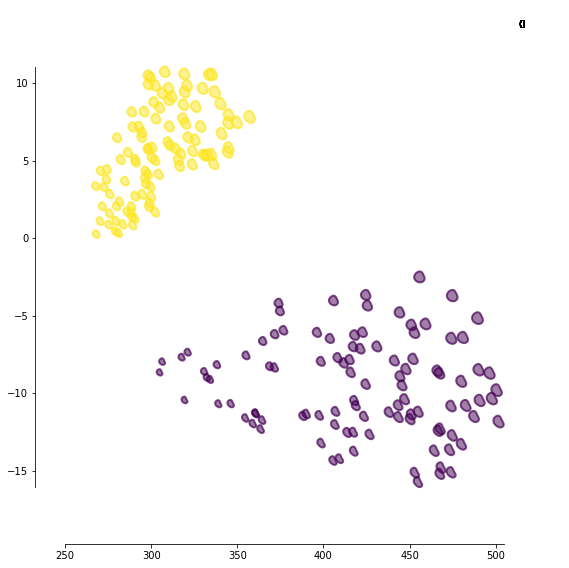

In [23]:
anim = vc_samples.morph_space('stxy', 'parafac', shape_size=0.5, 
                              show_shapes=True, colorcode='label')


In [24]:
anim

In [22]:
anim, recon_contours, recon_positions, num_points = \
                        vc_samples.morph_space_reconstruction('stxy', 'parafac', 
                                  num_points=8, num_dimensions=2, sigma=[4,4],
                                  shape_size=.3, duration=5.0,
                                  return_contours=True)
anim

(64, 2)
reconstruct_tensor reconstruction.shape:  (64, 41, 96)
format =  stxy
num_videos =  64
num_frames =  41
factors.shape =  2


`pca` embedding for `contours` done (0.17 s).


/Users/wdeback/Work/cellshapy/cellshapy/analysis/timeseries.py:72: RuntimeWarning: invalid value encountered in less
  significant = (acf > z99 / np.sqrt(n))
/Users/wdeback/Work/cellshapy/cellshapy/analysis/timeseries.py:239: RuntimeWarning: invalid value encountered in less
  first_negative = np.argmax(np.array(acf) < 0.0)


Cluster 0, size = 100
Cluster 1, size = 100
Adjusted alpha (bonf): 1.1904761904761905e-05


/Users/wdeback/anaconda/envs/cellshapy/lib/python3.6/site-packages/statsmodels/stats/multitest.py:147: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals <= alphacBonf
/Users/wdeback/anaconda/envs/cellshapy/lib/python3.6/site-packages/statsmodels/stats/multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


0
perimeter hull__std             2.120109e-32
major axis length__trend        2.120109e-32
max caliper diameter__std       2.120109e-32
max caliper diameter__trend     2.120109e-32
mean curvature__trend           2.120109e-32
min caliper diameter__trend     2.120109e-32
minor axis length__trend        2.120109e-32
equivalent diameter__trend      2.120109e-32
perimeter hull__trend           2.120109e-32
area__trend                     2.120109e-32
major axis length__std          2.120109e-32
area to perimeter ratio__trend  2.120109e-32
area hull__trend                2.120109e-32
perimeter__std                  2.120109e-32
perimeter__trend                2.120109e-32
mean_pairwise_distance          2.390763e-32
equivalent diameter__std        2.695714e-32
area to perimeter ratio__std    7.675661e-32
area hull__std                  1.033658e-31
area__std                       1.164150e-31
mean curvature__std             1.520656e-31
circularity__trend              8.916192e-31
length                          2.406291e-30
tortuosity                      2.794136e-29
minor axis length__std          1.126363e-28
min caliper diameter__std       4.603569e-28
major axis length__noise        9.000962e-28
waviness__trend                 1.249642e-25
max caliper diameter__noise     3.269541e-24
solidity__trend                 9.939173e-23
eccentricity__trend             4.246738e-17
elongation__trend               2.765613e-16
hull_volume_robust              3.586152e-15
hull_volume_all                 2.189937e-14
solidity__std                   2.600077e-14
circularity__std                3.558803e-14
waviness__mean                  6.376016e-14
solidity__mean                  2.133141e-13
eccentricity__noise             3.833375e-13
waviness__std                   4.790202e-13
waviness__noise                 4.574849e-12
solidity__noise                 1.668507e-11
min caliper diameter__noise     4.519567e-11
aspect ratio__trend             4.439913e-10
hull_volume_core                3.497926e-08
aspect ratio__noise             1.749818e-07
aspect ratio__std               1.413688e-06
major axis length__mean         3.712825e-06
eccentricity__std               5.995581e-06
max caliper diameter__mean      1.027812e-05
circularity__mean               2.335415e-04
perimeter__mean                 3.068302e-04
perimeter hull__mean            3.141542e-04
circularity__noise              6.453336e-04
elongation__std                 9.173024e-04

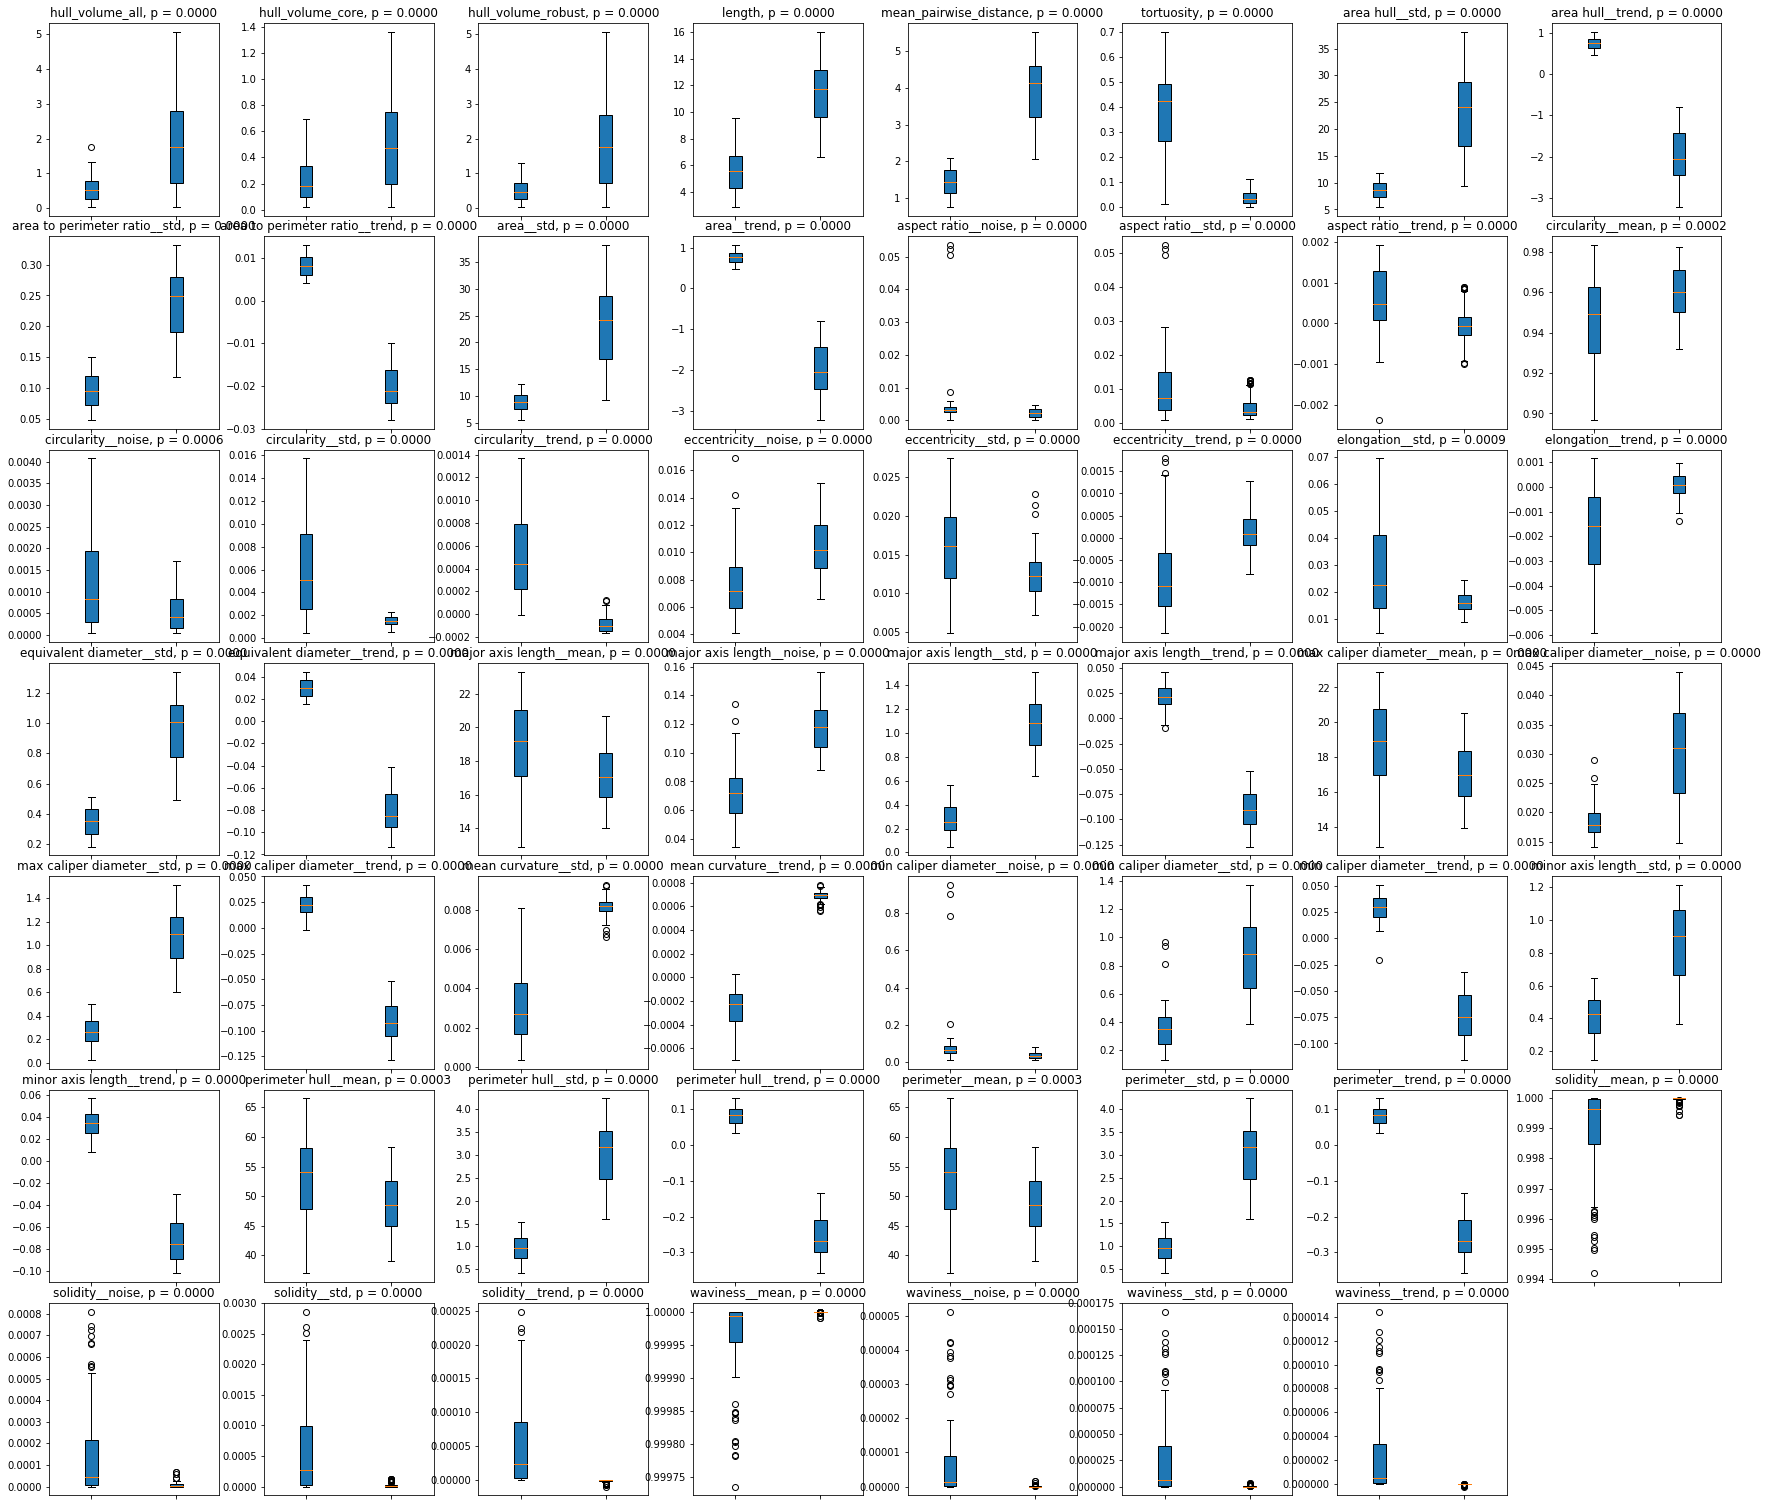

In [43]:
vc_samples.embed_frames('contours', 'pca', n_components=2)
result = vc_samples.cluster_comparison(cluster_label='label', multipletest_corr='bonf', alpha=0.001)
result.to_frame()

In [42]:
result.to_frame()

0
perimeter hull__std             2.120109e-32
major axis length__trend        2.120109e-32
max caliper diameter__std       2.120109e-32
max caliper diameter__trend     2.120109e-32
mean curvature__trend           2.120109e-32
min caliper diameter__trend     2.120109e-32
minor axis length__trend        2.120109e-32
equivalent diameter__trend      2.120109e-32
perimeter hull__trend           2.120109e-32
area__trend                     2.120109e-32
major axis length__std          2.120109e-32
area to perimeter ratio__trend  2.120109e-32
area hull__trend                2.120109e-32
perimeter__std                  2.120109e-32
perimeter__trend                2.120109e-32
mean_pairwise_distance          2.390763e-32
equivalent diameter__std        2.695714e-32
area to perimeter ratio__std    7.675661e-32
area hull__std                  1.033658e-31
area__std                       1.164150e-31
mean curvature__std             1.520656e-31
circularity__trend              8.916192e-31
length                          2.406291e-30
tortuosity                      2.794136e-29
minor axis length__std          1.126363e-28
min caliper diameter__std       4.603569e-28
major axis length__noise        9.000962e-28
waviness__trend                 1.249642e-25
max caliper diameter__noise     3.269541e-24
solidity__trend                 9.939173e-23
eccentricity__trend             4.246738e-17
elongation__trend               2.765613e-16
hull_volume_robust              3.586152e-15
hull_volume_all                 2.189937e-14
solidity__std                   2.600077e-14
circularity__std                3.558803e-14
waviness__mean                  6.376016e-14
solidity__mean                  2.133141e-13
eccentricity__noise             3.833375e-13
waviness__std                   4.790202e-13
waviness__noise                 4.574849e-12
solidity__noise                 1.668507e-11
min caliper diameter__noise     4.519567e-11
aspect ratio__trend             4.439913e-10
hull_volume_core                3.497926e-08
aspect ratio__noise             1.749818e-07
aspect ratio__std               1.413688e-06
major axis length__mean         3.712825e-06
eccentricity__std               5.995581e-06
max caliper diameter__mean      1.027812e-05
circularity__mean               2.335415e-04
perimeter__mean                 3.068302e-04
perimeter hull__mean            3.141542e-04
circularity__noise              6.453336e-04
elongation__std                 9.173024e-04